# Evaluation
Data Systems Project, Group F4

In [33]:
import pandas as pd
import nltk
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.util import ngrams
from textstat import flesch_reading_ease
import re
import string
from scipy.stats import mannwhitneyu, ttest_ind, levene
from statistics import median, mean

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/katonazsofia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Loading original and text-extracted datasets

In [22]:
# Loading original taxonomy.
df = pd.read_excel("taxonomy.xlsx")

# Relevant sectors.
sectors = ['Forestry', 'Construction and real estate']

# Select construction sector
df_relevant = df[df["Sector"].isin(sectors)]

# Handle missing values by substituting empty string.
df_relevant = df_relevant.fillna('')

df_relevant.head()

,NACE,Sector,Activity number,Activity,Contribution type,Description,Substantial contribution criteria,DNSH on Climate adaptation,DNSH on Water,DNSH on Circular economy,DNSH on Pollution prevention,DNSH on Biodiversity,Unnamed: 12,Footnotes
0,A2,Forestry,1.1,Afforestation,,"Establishment of forest through planting, deli...",1. Afforestation plan and subsequent forest ma...,The activity complies with the criteria set ou...,The activity complies with the criteria set ou...,,The use of pesticides is reduced and alternati...,In areas designated by the national competent ...,,(1) Establishment of forest through planting o...
1,A2,Forestry,1.2,"Rehabilitation and restoration of forests, inc...",,Rehabilitation and restoration of forests as d...,1. Forest management plan or equivalent instru...,The activity complies with the criteria set ou...,The activity complies with the criteria set ou...,The silvicultural change induced by the activi...,The use of pesticides is reduced and alternati...,In areas designated by the national competent ...,,(21) Forest restoration includes: (22) Ecologi...
2,A2,Forestry,1.3,Forest management,,Forest management as defined by national law. ...,1. Forest management plan or equivalent instru...,The activity complies with the criteria set ou...,The activity complies with the criteria set ou...,The silvicultural change induced by the activi...,The use of pesticides is reduced and alternati...,In areas designated by the national competent ...,,"(39) Land spanning more than 0,5 hectares with..."
3,A2,Forestry,1.4,Conservation forestry,,Forest management activities with the objectiv...,1. Forest management plan or equivalent instru...,The activity complies with the criteria set ou...,The activity complies with the criteria set ou...,The silvicultural change induced by the activi...,The activity does not use pesticides or fertil...,In areas designated by the national competent ...,,"(50) Land spanning more than 0,5 hectares with..."
82,"F41.1, F41.2, F43",Construction and real estate,7.1,Construction of new buildings,,Development of building projects for residenti...,Constructions of new buildings for which:1. Th...,The activity complies with the criteria set ou...,"Where installed, except for installations in r...",At least 70 % (by weight) of the non-hazardous...,Building components and materials used in the ...,The activity complies with the criteria set ou...,,(290) The calculated amount of energy needed t...


In [18]:
# Loading text-extracted information.

objectives = ['mitigation', 'adaptation']
sectors = ['forestry', 'construction']

ex_dfs = [pd.read_csv(f'extracted_{objective}_{sector}.csv') \
                      for objective in objectives for sector in sectors]

ex_df = pd.concat(ex_dfs, axis=0, ignore_index=True)

ex_df.head()

,Unnamed: 0,activity_name,node,list_of_external_resources,has_limitations
0,0,Afforestation,1.1,"['http://www.fao.org/3/I8661EN/i8661en.pdf', '...",['Afforestation implies a transformation of la...
1,1,Afforestation,1.1_mitigation_SubstantialContributionCriteria,['https://www.foresteurope.org/docs/other_meet...,['The afforestation plan must cover a duration...
2,2,Afforestation,1.1_mitigation_DNSHonClimateAdaptation,['Appendix A to this Annex'],[]
3,3,Afforestation,1.1_mitigation_DNSHonWater,['Appendix B to this Annex'],[]
4,4,Afforestation,1.1_mitigation_DNSHonCircularEconomy,[],[]


In [23]:
text_col_indeces = [i for i in range(6,12)]

text_col_names = [name for name in df_relevant.columns[text_col_indeces[0]:text_col_indeces[-1]+1]]

print('Name of free text columns:')
for name in text_col_names:
    print(name)

Name of free text columns:
Substantial contribution criteria
DNSH on Climate adaptation
DNSH on Water
DNSH on Circular economy
DNSH on Pollution prevention
DNSH on Biodiversity


## Comparing reading ease

This comparison is done between the original free-text bodies of the taxonomy (one per free-text column per activity) and the pieces of free text containing the extracted limitations (possibly several per free-text column per activity).

In [24]:
fre_scores = {'Original' : [], 'Extracted' : []}

for col in text_col_names:
    for cell in df_relevant[col]:
        if cell != '':
            fre_scores['Original'].append(flesch_reading_ease(cell))


for limitations in ex_df['has_limitations']:
    for limitation in eval(limitations):
        fre_scores['Extracted'].append(flesch_reading_ease(limitation))

In [25]:
for key, scores in fre_scores.items():
    print(f'{key} number of bodies of free-text: {len(scores)}')

Original number of bodies of free-text: 46
Extracted number of bodies of free-text: 167


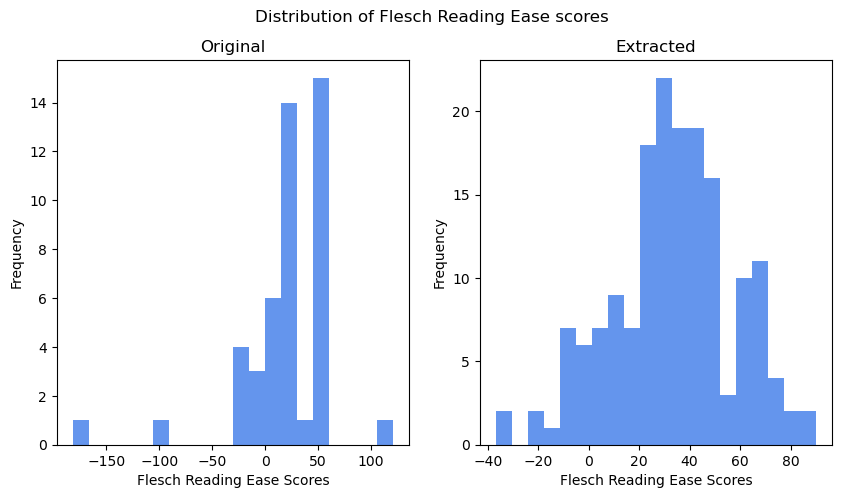

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Distribution of Flesch Reading Ease scores')

for i, (key, scores) in enumerate(fre_scores.items()):
    ax[i].hist(scores, color='cornflowerblue', bins=20)

    ax[i].set_title(f'{key}')
    ax[i].set_xlabel('Flesch Reading Ease Scores')
    ax[i].set_ylabel('Frequency')

plt.show()

In [36]:
for key, scores in fre_scores.items():
    print(f'Mean FRE score in {key.lower()} bodies of free text: {mean(scores):.2f}')

Mean FRE score in original bodies of free text: 21.15
Mean FRE score in extracted bodies of free text: 33.13


In [28]:
statistic, p_value = levene(fre_scores['Extracted'], fre_scores['Original'])

alpha = 0.05

if p_value < alpha:
    print(f"The variances are significantly different (p-value: {p_value})")
else:
    print(f"No significant difference in variances (p-value: {p_value})")

The variances are significantly different (p-value: 0.0037727276562254056)


In [31]:
t_statistic, p_value = ttest_ind(fre_scores['Extracted'], fre_scores['Original'], 
                                 alternative='greater', equal_var=False)

# Check the p-value to determine significance
alpha = 0.05  # Set your desired significance level
if p_value < alpha:
    print(f"The means are significantly different (p-value: {p_value})")
else:
    print(f"No significant difference in means (p-value: {p_value})")

The means are significantly different (p-value: 0.04650342887729865)


In [30]:
statistic, p_value = mannwhitneyu(fre_scores['Extracted'], fre_scores['Original'], alternative='greater')

alpha = 0.05

if p_value < alpha:
    print(f"The means are significantly different (p-value: {p_value})")
else:
    print(f"No significant difference in means (p-value: {p_value})")

The means are significantly different (p-value: 0.029908842956904977)
